# **Proyecto 1**

Integrantes:


*   Niño Pedraza Eduardo
*   Reyes Ramírez Raquel
*   Salas Cortés Emiliano

A continuación se hace el uso de una base de datos reales de los precios de los CETES usando el modelo de Hull & White

In [1]:
#Importamos las paqueterías necesarias
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import norm
import math

In [2]:
# Datos de precios CETES
precios = np.array([9.932081, 9.777824, 9.569892, 9.202720, 8.553793])
vencimientos = [
    "2025-04-16", "2025-06-19", "2025-09-18", "2026-03-05", "2027-01-21"
]
fecha_base = datetime.date(2025, 3, 25)
dias = np.array([(datetime.date.fromisoformat(v) - fecha_base).days for v in vencimientos])
años = dias / 360
valor_nominal = 10
tasas = ((valor_nominal / precios) - 1) * (360 / dias)


print("Tasas implícitas:")
for d, r in zip(dias, tasas):
    print(f"{d} días: {r:.4%}")

Tasas implícitas:
22 días: 11.1900%
86 días: 9.5117%
177 días: 9.1411%
345 días: 9.0402%
667 días: 9.1253%


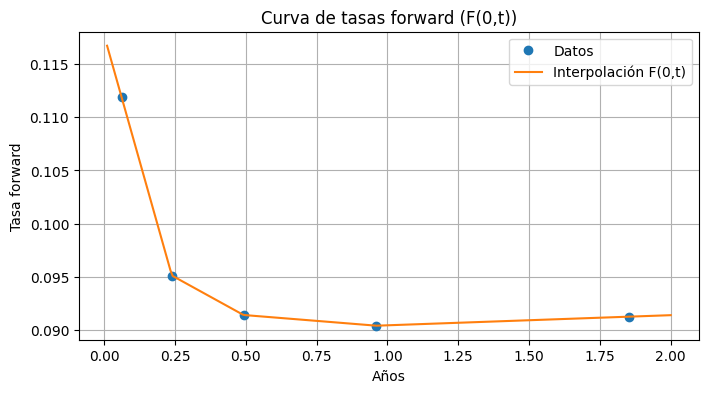

In [3]:
# Interpolación de la curva F(0,t)
F_0_t = interp1d(años, tasas, kind='linear', fill_value="extrapolate")

# Rango de tiempo para evaluación
tiempo = np.linspace(0.01, 2.0, 250)
delta = tiempo[1] - tiempo[0]

# Derivada de F(0,t)
dF0_dt_valores = np.gradient(F_0_t(tiempo), tiempo)
dF0_dt = interp1d(tiempo, dF0_dt_valores, kind='cubic', fill_value="extrapolate")

plt.figure(figsize=(8, 4))
plt.plot(años, tasas, 'o', label="Datos")
plt.plot(tiempo, F_0_t(tiempo), '-', label="Interpolación F(0,t)")
plt.xlabel("Años")
plt.ylabel("Tasa forward")
plt.title("Curva de tasas forward (F(0,t))")
plt.grid(True)
plt.legend()
plt.show()


In [4]:
# Función θ(t)
def theta(t, a, sigma):
    return dF0_dt(t) + a * F_0_t(t) + (sigma**2) / (2 * a) * (1 - np.exp(-2 * a * t))

# Log-verosimilitud negativa
def log_verosimilitud(parametros, tiempo, tasas, F_0_t):
    a, sigma = parametros
    if a <= 0 or sigma <= 0:
        return np.inf
    media = F_0_t(tiempo) + (sigma**2 / (2 * a**2)) * (1 - np.exp(-a * tiempo))**2
    varianza = (sigma**2 / (2 * a)) * (1 - np.exp(-2 * a * tiempo))
    logL = -0.5 * np.sum(np.log(2 * np.pi * varianza) + ((tasas - media)**2) / varianza)
    return -logL

In [5]:
# Escenarios de prueba
escenarios = [
    (1, 0.008),
    (0.01, 0.03),
    (0.5, 0.05),
    (1.0, 0.1),
    (2.0, 0.03)
]

puntos_iniciales = [
    [1200, 2000],
    [320, 500],
    [63, 89],
    [17, 12],
    [7, 5],
    [1, 1],
    [0.1, 0.3],
    [0.05, 0.01],
    [0, 0],
    [1, 1]
]


In [6]:
# Resultados a guardar
theta_estimadas = []
tasas_promedio_lista = []
parametros_estimados = []

# Estimación para cada escenario
for a_inicial, sigma_inicial in escenarios:
    print(f"\nProcesando con a={a_inicial}, sigma={sigma_inicial}")

    for j in range(100):
        theta_vals = theta(tiempo, a_inicial, sigma_inicial)

        # Simulación de 1000 trayectorias
        simulaciones = []
        for _ in range(1000):
            r = np.zeros_like(tiempo)
            r[0] = F_0_t(tiempo[0])
            for i in range(1, len(tiempo)):
                th = theta_vals[i-1]
                r[i] = r[i-1] + (th - a_inicial * r[i-1]) * delta + sigma_inicial * np.sqrt(delta) * np.random.normal()
            simulaciones.append(r)

        # Promedio de trayectorias
        tasas_promedio = np.mean(simulaciones, axis=0)

        punto_ini = puntos_iniciales[math.floor(j / 10)]

        resultado = minimize(
            log_verosimilitud, x0=punto_ini,
            args=(tiempo, tasas_promedio, F_0_t),
            method='L-BFGS-B', bounds=[(1e-5, None), (1e-5, None)]
        )
        a_estimado, sigma_estimado = resultado.x

        a_anterior, sigma_anterior = a_inicial, sigma_inicial

        np.random.seed(42)
        t_muestra = np.random.choice(tiempo, size=5, replace=False)

        theta_estimada = theta(t_muestra, a_estimado, sigma_estimado)
        theta_anterior = theta(t_muestra, a_anterior, sigma_anterior)
        F_muestra = F_0_t(t_muestra)

        error_nuevo = np.mean((theta_estimada - F_muestra)**2)
        error_viejo = np.mean((theta_anterior - F_muestra)**2)

        # Aceptación de nuevos parámetros si mejora el ajuste a F(0,t)
        if error_nuevo < error_viejo:
            a_inicial, sigma_inicial = a_estimado, sigma_estimado
        else:
            a_inicial, sigma_inicial = a_anterior, sigma_anterior

    print(f"Estimación final: â = {a_estimado:.4f}, σ̂ = {sigma_estimado:.4f}")

    # Resultados finales del escenario
    theta_final = theta(tiempo, a_inicial, sigma_inicial)
    parametros_estimados.append((a_estimado, sigma_estimado))
    theta_estimadas.append(theta_final)
    tasas_promedio_lista.append(tasas_promedio)


Procesando con a=1, sigma=0.008
Estimación final: â = 2.9593, σ̂ = 0.0004

Procesando con a=0.01, sigma=0.03
Estimación final: â = 2.2133, σ̂ = 0.0005

Procesando con a=0.5, sigma=0.05
Estimación final: â = 0.3749, σ̂ = 0.0010

Procesando con a=1.0, sigma=0.1
Estimación final: â = 0.2110, σ̂ = 0.0022

Procesando con a=2.0, sigma=0.03
Estimación final: â = 4.2076, σ̂ = 0.0004


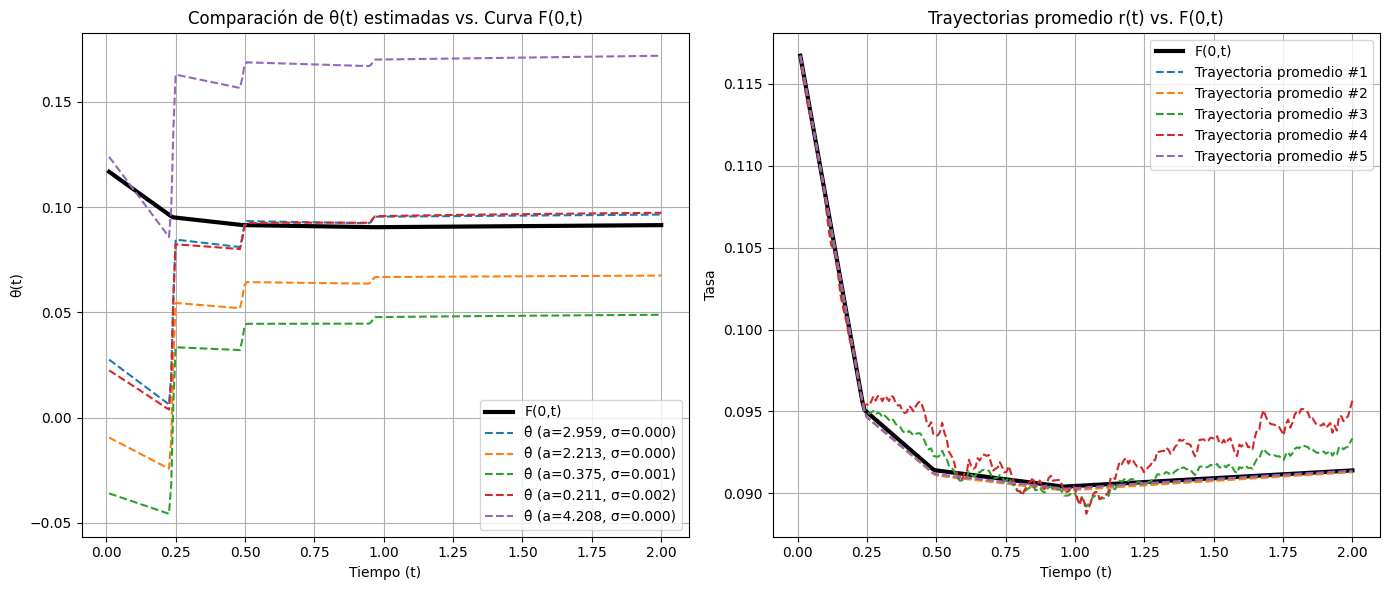

In [7]:
# Gráficas comparativas
plt.figure(figsize=(14, 6))

# Comparación θ estimada vs F(0,t)
plt.subplot(1, 2, 1)
plt.plot(tiempo, F_0_t(tiempo), label='F(0,t)', linewidth=3, color='black')
for i, theta_est in enumerate(theta_estimadas):
    a_est, sigma_est = parametros_estimados[i]
    plt.plot(tiempo, theta_est, linestyle='--', label=f'θ̂ (a={a_est:.3f}, σ={sigma_est:.3f})')
plt.xlabel('Tiempo (t)')
plt.ylabel('θ(t)')
plt.title('Comparación de θ(t) estimadas vs. Curva F(0,t)')
plt.grid(True)
plt.legend()

# Comparación r_t promedio vs F(0,t)
plt.subplot(1, 2, 2)
plt.plot(tiempo, F_0_t(tiempo), label='F(0,t)', linewidth=3, color='black')
for i, r in enumerate(tasas_promedio_lista):
    plt.plot(tiempo, r, linestyle='--', label=f'Trayectoria promedio #{i+1}')
plt.xlabel('Tiempo (t)')
plt.ylabel('Tasa')
plt.title('Trayectorias promedio r(t) vs. F(0,t)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# Seleccionar 5 tiempos de evaluación (pueden ser aleatorios o elegidos)
tiempos_seleccionados = np.array(tiempo[0:250:50])
print(f"Tiempos seleccionados: {np.round(tiempos_seleccionados, 4)}\n")

# Evaluar la curva forward F(0,t) en esos tiempos
valores_forward = F_0_t(tiempos_seleccionados)
print("Valores de F(0,t):")
for t, f in zip(tiempos_seleccionados, valores_forward):
    print(f"t = {t:.4f} años → F(0,t) = {f:.4%}")

# Evaluar las tasas promedio simuladas r̄(t) en esos tiempos, por escenario
for i, tasas_prom in enumerate(tasas_promedio_lista):
    tasas_eval = np.interp(tiempos_seleccionados, tiempo, tasas_prom)
    print(f"\nEscenario #{i+1} (a={escenarios[i][0]}, σ={escenarios[i][1]}) — r̄(t) en tiempos seleccionados:")
    for t, r in zip(tiempos_seleccionados, tasas_eval):
        print(f"t = {t:.4f} años → r̄(t) = {r:.4%}")

Tiempos seleccionados: [0.01   0.4096 0.8092 1.2088 1.6084]

Valores de F(0,t):
t = 0.0100 años → F(0,t) = 11.6725%
t = 0.4096 años → F(0,t) = 9.2614%
t = 0.8092 años → F(0,t) = 9.0725%
t = 1.2088 años → F(0,t) = 9.0640%
t = 1.6084 años → F(0,t) = 9.1021%

Escenario #1 (a=1, σ=0.008) — r̄(t) en tiempos seleccionados:
t = 0.0100 años → r̄(t) = 11.6725%
t = 0.4096 años → r̄(t) = 9.2354%
t = 0.8092 años → r̄(t) = 9.0504%
t = 1.2088 años → r̄(t) = 9.0488%
t = 1.6084 años → r̄(t) = 9.0919%

Escenario #2 (a=0.01, σ=0.03) — r̄(t) en tiempos seleccionados:
t = 0.0100 años → r̄(t) = 11.6725%
t = 0.4096 años → r̄(t) = 9.2342%
t = 0.8092 años → r̄(t) = 9.0464%
t = 1.2088 años → r̄(t) = 9.0438%
t = 1.6084 años → r̄(t) = 9.0867%

Escenario #3 (a=0.5, σ=0.05) — r̄(t) en tiempos seleccionados:
t = 0.0100 años → r̄(t) = 11.6725%
t = 0.4096 años → r̄(t) = 9.3686%
t = 0.8092 años → r̄(t) = 8.9977%
t = 1.2088 años → r̄(t) = 9.0851%
t = 1.6084 años → r̄(t) = 9.1627%

Escenario #4 (a=1.0, σ=0.1) — r̄(t) en

In [9]:
print("\n==== Valuación de CETES y comparación por escenario ====\n")

for i, tasas_prom in enumerate(tasas_promedio_lista):
    # Tasas forward reales y simuladas en los tiempos seleccionados
    tasas_real = F_0_t(tiempos_seleccionados)
    tasas_simulada = np.interp(tiempos_seleccionados, tiempo, tasas_prom)

    # Valuación de CETES
    precios_reales = valor_nominal / (1 + tasas_real * tiempos_seleccionados)
    precios_simulados = valor_nominal / (1 + tasas_simulada * tiempos_seleccionados)

    # Diferencias
    diferencias = precios_simulados - precios_reales

    print(f"Escenario #{i+1} (a={escenarios[i][0]}, σ={escenarios[i][1]})")
    print("Tiempo  |  Precio real  |  Precio simulado  |  Pérdida/Ganancia")
    print("-" * 60)
    for t, p_real, p_sim, diff in zip(tiempos_seleccionados, precios_reales, precios_simulados, diferencias):
        signo = "+" if diff >= 0 else "-"
        print(f"{t:.4f}   |   {p_real:.4f}      |     {p_sim:.4f}         |    {signo}{abs(diff):.4f}")
    print()


==== Valuación de CETES y comparación por escenario ====

Escenario #1 (a=1, σ=0.008)
Tiempo  |  Precio real  |  Precio simulado  |  Pérdida/Ganancia
------------------------------------------------------------
0.0100   |   9.9883      |     9.9883         |    +0.0000
0.4096   |   9.6345      |     9.6355         |    +0.0010
0.8092   |   9.3161      |     9.3176         |    +0.0015
1.2088   |   9.0125      |     9.0140         |    +0.0015
1.6084   |   8.7230      |     8.7242         |    +0.0012

Escenario #2 (a=0.01, σ=0.03)
Tiempo  |  Precio real  |  Precio simulado  |  Pérdida/Ganancia
------------------------------------------------------------
0.0100   |   9.9883      |     9.9883         |    +0.0000
0.4096   |   9.6345      |     9.6356         |    +0.0010
0.8092   |   9.3161      |     9.3179         |    +0.0018
1.2088   |   9.0125      |     9.0145         |    +0.0020
1.6084   |   8.7230      |     8.7249         |    +0.0019

Escenario #3 (a=0.5, σ=0.05)
Tiempo  |  P


Evaluación del modelo Hull & White
RMSE: 0.000284
MAE: 0.000211


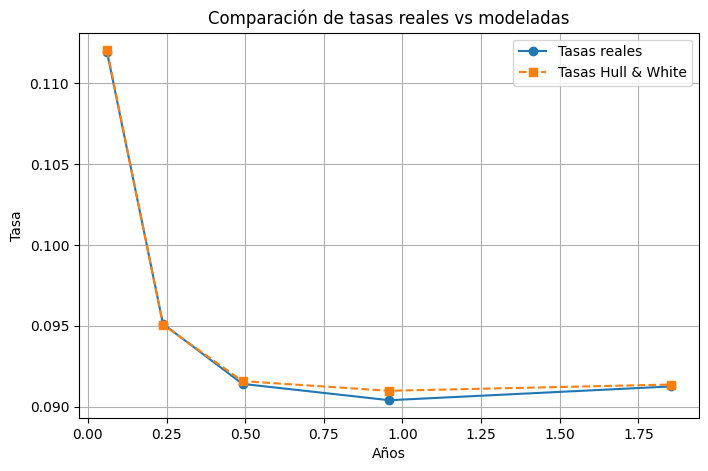

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Usar los parámetros óptimos conocidos o elegidos (puedes cambiar esto)
a_estimado = 1.0
sigma_estimado = 0.03

# Calcular theta con los parámetros estimados
theta_val = theta(tiempo, a_estimado, sigma_estimado)

# Simular tasas en los puntos deseados
simulaciones = []
for _ in range(1000):
    r = np.zeros_like(tiempo)
    r[0] = F_0_t(tiempo[0])
    for i in range(1, len(tiempo)):
        th = theta_val[i - 1]
        r[i] = r[i - 1] + (th - a_estimado * r[i - 1]) * delta + sigma_estimado * np.sqrt(delta) * np.random.normal()
    simulaciones.append(r)

# Promedio de tasas simuladas
tasas_simuladas_promedio = np.mean(simulaciones, axis=0)

# Interpolamos el resultado a los puntos de años reales
tasas_modeladas_en_puntos = np.interp(años, tiempo, tasas_simuladas_promedio)

# Comparación con tasas reales
rmse = np.sqrt(mean_squared_error(tasas, tasas_modeladas_en_puntos))
mae = mean_absolute_error(tasas, tasas_modeladas_en_puntos)

print("\nEvaluación del modelo Hull & White")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")

# Visualización
plt.figure(figsize=(8, 5))
plt.plot(años, tasas, 'o-', label='Tasas reales')
plt.plot(años, tasas_modeladas_en_puntos, 's--', label='Tasas Hull & White')
plt.xlabel("Años")
plt.ylabel("Tasa")
plt.title("Comparación de tasas reales vs modeladas")
plt.legend()
plt.grid(True)
plt.savefig("comparacion_tasas_hull_white.png", dpi=300)
plt.show()

In [22]:
from scipy.stats import ks_2samp

# Obtener las tasas simuladas en los mismos años que los datos reales
tasas_simuladas_en_puntos = np.array([
    np.interp(años, tiempo, simulacion) for simulacion in simulaciones
])

# Aplanamos todas las tasas simuladas en los puntos observados
tasas_simuladas_flat = tasas_simuladas_en_puntos.flatten()
tasas_reales_rep = np.tile(tasas, (tasas_simuladas_en_puntos.shape[0], 1)).flatten()

# Prueba K-S
ks_stat, ks_p = ks_2samp(tasas_reales_rep, tasas_simuladas_flat)

print(f"Prueba de Kolmogorov-Smirnov:")
print(f"Estadístico: {ks_stat:.4f}, p-valor: {ks_p:.4f}")


Prueba de Kolmogorov-Smirnov:
Estadístico: 0.3526, p-valor: 0.0000


In [23]:
from scipy.stats import shapiro

residuos = tasas - tasas_modeladas_en_puntos
shapiro_stat, shapiro_p = shapiro(residuos)

print(f"Prueba de normalidad (Shapiro-Wilk) sobre residuos:")
print(f"Estadístico: {shapiro_stat:.4f}, p-valor: {shapiro_p:.4f}")


Prueba de normalidad (Shapiro-Wilk) sobre residuos:
Estadístico: 0.8528, p-valor: 0.2035
